# Finding Critical Points with TensorFlow
## Part 2 - Critical Points of Neural Networks

This section is under construction.

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import namedtuple

import utils

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4

The tricky part here is specifying the parameters: in order to calculate a Hessian, we need the parameters to be inside the same variable, but TensorFlow is not designed with the expectation that all of our weights need to be initialized at once. In addition, this makes keeping abstraction barriers up more difficult.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The biggest practical issue is handling the non-invertibility of the Hessian and related numerical issues in the Newton method. Seems like it requires fairly careful tuning of the step size, or else it can cause the performance to drop and/or the (raw) gradients to blow up.

Need to look into trust region methods more closely for intuition about how to set this.

Tested with batch size 50k -- doesn't seem to be an error in estimating the Hessian.

01-24-2018 - Added pseudo-inverse based on Jesse's code. Gradient norm now goes down a bit and doesn't increase substantially, but it's not as small as I'd like.

Note - if cost function is piecewise linear in the parameters, then gradient norm need not go to zero.

The gradient norm also won't go to zero if you're circling a critical point -- which might happen if your step size is too large.

In [11]:
fudged_hess_hyperparameters = {"layer_sizes":[10],
                            "nonlinearity":tf.nn.relu,
                            "input_size":784,
                            "output_size":10,
                             "learning_rate":0.01,
                             "newton_rate":5e-5,
                             "fudge_factor":1e-8,
                             "inverse_method": "fudged"
                            }

pseudo_inverse_hyperparameters = {"layer_sizes":[10],
                            "nonlinearity":tf.nn.relu,
                            "input_size":784,
                            "output_size":10,
                             "learning_rate":0.01,
                             "newton_rate":1e-3,
                             "minimum_eigenvalue_magnitude":1e-1,
                             "inverse_method": "pseudo"
                            }

gradmin_hyperparameters = {"layer_sizes":[10],
                            "nonlinearity":tf.nn.relu,
                            "input_size":784,
                            "output_size":10,
                            "learning_rate":0.01,
                            "newton_rate":1e-3,
                            "grad_norm_learning_rate":1e-3,
                            "minimum_eigenvalue_magnitude":1e-1,
                            "inverse_method": "pseudo"
                            }

In [6]:
# %pdb on

In [12]:
network = utils.make_neural_network(gradmin_hyperparameters)

In [13]:
graph = network.graph
graph_dict = network.graph_dictionary
hyperparameter_dictionary = network.hyperparameter_dictionary
num_parameters = hyperparameter_dictionary["num_parameters"]
total_weights = hyperparameter_dictionary["total_weights"]
total_biases = hyperparameter_dictionary["total_biases"]
initialized_parameters = np.hstack([0.1*np.random.standard_normal(size=total_weights),
                                  [0.1]*total_biases]).astype(np.float32)

In [14]:
num_batches_init = 5000
num_gradmin_steps = 10000

gradient_descent_batch_size = 50
tracking_batch_size = 50000
gradmin_batch_size = 10000

with graph.as_default():
    sess = tf.InteractiveSession()
    input = graph_dict["input"]
    labels = graph_dict["labels"]
    initial_parameters = graph_dict["parameters_placeholder"]
    trained_parameters = graph_dict["parameters"]
    step_gradient_descent = graph_dict["step_gradient_descent"]
    step_newton = graph_dict["step_newton"]
    step_gradmin = graph_dict["step_gradmin"]
    accuracy = graph_dict["accuracy"]
    cost = graph_dict["cost"]
    gradient_op = graph_dict["gradients"]
    
    initializer_feed_dict = {initial_parameters: initialized_parameters}
    tf.global_variables_initializer().run(initializer_feed_dict)    
    
    for batch_idx in range(num_batches_init):
        
        if (batch_idx+1 == 1):
            
            batch_inputs, batch_labels = mnist.train.next_batch(tracking_batch_size)
            train_feed_dict = {input: batch_inputs,
                       labels: batch_labels}
            
            current_cost = sess.run(cost, feed_dict=train_feed_dict)
            init_gradients = sess.run(gradient_op, feed_dict=train_feed_dict)
            gradient_norm = np.linalg.norm(init_gradients)
            
            print("init values")
            print("\tcost: {0:.2f}".format(current_cost))
            print("\tgrad_norm: {0:.10f}".format(gradient_norm))
            
            gradient_max = np.max(np.abs(init_gradients))
            gradient_min = np.min(np.abs(init_gradients))
            print("\tgrad_max: {0:.10f}".format(gradient_max))
            
        batch_inputs, batch_labels = mnist.train.next_batch(gradient_descent_batch_size)
        train_feed_dict = {input: batch_inputs,
                       labels: batch_labels}
        
        sess.run(step_gradient_descent, feed_dict=train_feed_dict)

        if (batch_idx+1 == 1) or ((batch_idx+1)%500 == 0):
            
            batch_inputs, batch_labels = mnist.train.next_batch(tracking_batch_size)
            train_feed_dict = {input: batch_inputs,
                       labels: batch_labels}
            
            current_cost = sess.run(cost, feed_dict=train_feed_dict)
        
            gradients = sess.run(gradient_op, feed_dict=train_feed_dict)
            gradient_norm = gradient_norm = np.linalg.norm(gradients)

            gradient_max = np.max(np.abs(gradients))
            gradient_min = np.min(np.abs(gradients))
            
            print("grad step: {0}".format(batch_idx+1))
            print("\tcost: {0:.2f}".format(current_cost))
            print("\tgrad_norm: {0:.10f}".format(gradient_norm))
            
            gradient_max = np.max(np.abs(gradients))
            print("\tgrad_max: {0:.10f}".format(gradient_max))
        
    for batch_idx in range(num_gradmin_steps):
        
        batch_inputs, batch_labels = mnist.train.next_batch(gradmin_batch_size)
        train_feed_dict = {input: batch_inputs,
                       labels: batch_labels}
        
        sess.run(step_gradmin, feed_dict=train_feed_dict)
        
        if (batch_idx+1)%500 == 0:
            
            batch_inputs, batch_labels = mnist.train.next_batch(tracking_batch_size)
            train_feed_dict = {input: batch_inputs,
                       labels: batch_labels}
            
            print("gradmin step: {0}".format(batch_idx+1))
            current_cost = sess.run(cost, feed_dict=train_feed_dict)
            print("\tcost: {0:.2f}".format(current_cost))
            gradients = sess.run(gradient_op, feed_dict=train_feed_dict)
            gradient_norm = np.linalg.norm(gradients)
            print("\tgrad_norm: {0:.10f}".format(gradient_norm))
            gradient_max = np.max(np.abs(gradients))
            print("\tgrad_max: {0:.10f}".format(gradient_max))
        
    sess.close()

init values
	cost: 2.32
	grad_norm: 0.3065016866
	grad_max: 0.0630831942
grad step: 1
	cost: 2.31
	grad_norm: 0.3060857952
	grad_max: 0.0633272827
grad step: 500
	cost: 1.77
	grad_norm: 0.3548561037
	grad_max: 0.0682427436
grad step: 1000
	cost: 1.24
	grad_norm: 0.2819641232
	grad_max: 0.0494325310
grad step: 1500
	cost: 0.95
	grad_norm: 0.2064587623
	grad_max: 0.0389420427
grad step: 2000
	cost: 0.79
	grad_norm: 0.1661296636
	grad_max: 0.0288032088
grad step: 2500
	cost: 0.69
	grad_norm: 0.1359980255
	grad_max: 0.0227647778
grad step: 3000
	cost: 0.62
	grad_norm: 0.1113386676
	grad_max: 0.0200484358
grad step: 3500
	cost: 0.57
	grad_norm: 0.0947779939
	grad_max: 0.0188402943
grad step: 4000
	cost: 0.53
	grad_norm: 0.0978959575
	grad_max: 0.0163226146
grad step: 4500
	cost: 0.50
	grad_norm: 0.0860534236
	grad_max: 0.0160876270
grad step: 5000
	cost: 0.48
	grad_norm: 0.0759807751
	grad_max: 0.0151067069
gradmin step: 500
	cost: 0.48
	grad_norm: 0.0669642836
	grad_max: 0.0152299814
gradm

Even with very small steps, we're unable to get grad_norm below `0.049`.

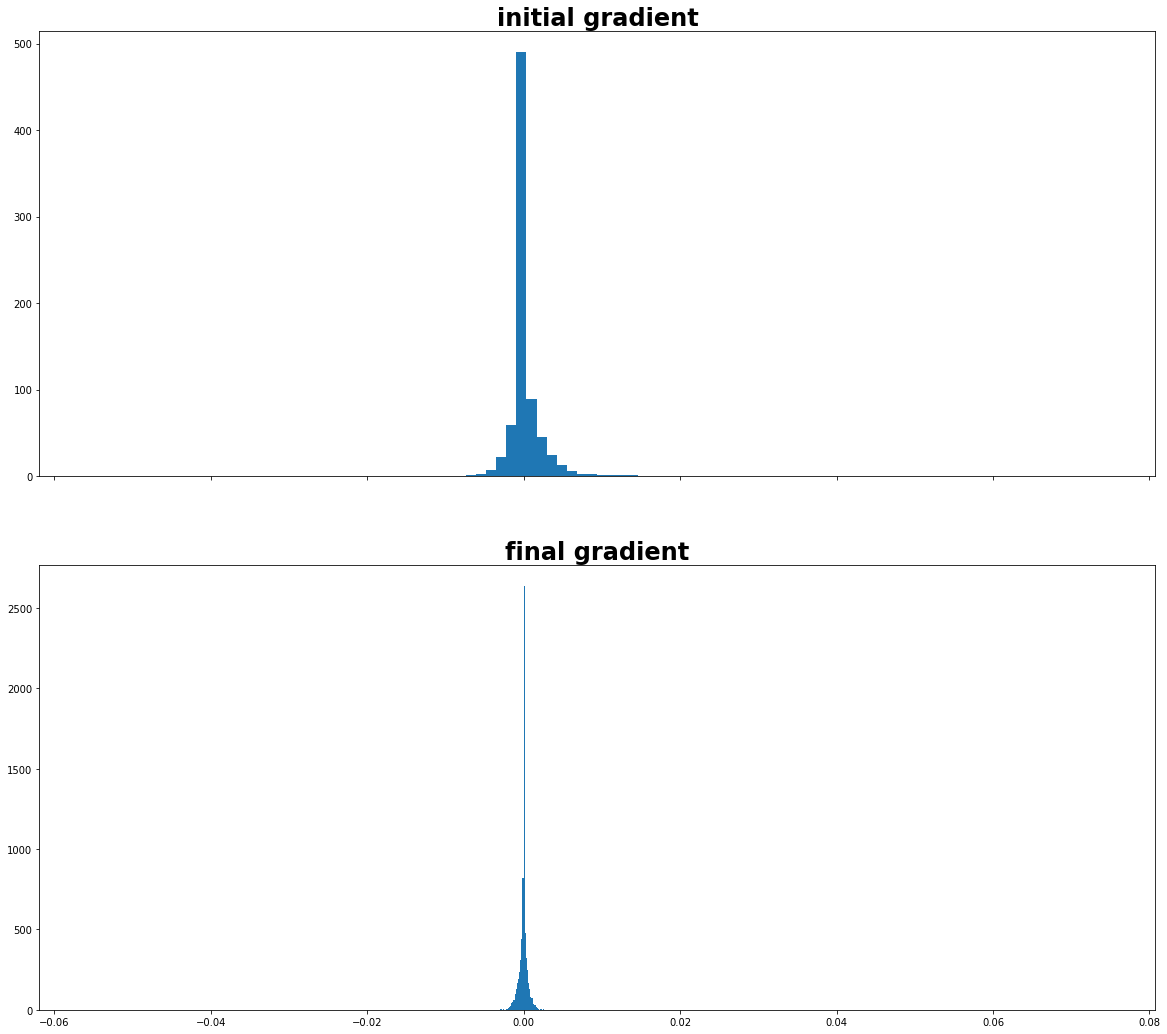

In [13]:
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(20,18), sharex=True)

axs[0].hist(init_gradients, normed=True, bins=100);
axs[0].set_title("initial gradient", fontsize=24, fontweight="bold");

axs[1].hist(gradients, normed=True, bins=100);
axs[1].set_title("final gradient", fontsize=24, fontweight="bold");

# axs[2].hist(accumulated_gradient, normed=True, bins=100);
# axs[2].set_title("accumulated gradient", fontsize=24, fontweight="bold");